In [39]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda, serializers
import chainer.functions as F
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import time
import datetime
from net import Net, MLP

In [40]:
n_epoch = 100000 #エポック
batchsize = 5000 #バッチサイズ
printout_interval = 1000 #何エポック毎に誤差をプリントアウトするか

bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 20 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [41]:
xp = cuda.cupy if use_gpu is True else np

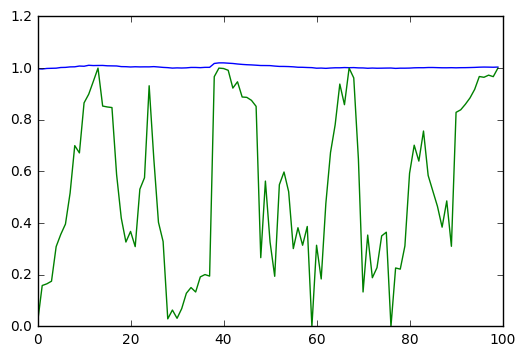

In [42]:
raw_data = []
f = open('nikkei5min.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    if row[9] == "" or row[7] == "":
        continue
    raw_data.append([row[7], row[9]])
raw_data = np.asarray(raw_data, dtype=np.float32)
raw_data = raw_data
data_x = raw_data[:, 0:1]
data_y = raw_data[:, 1:2]
train_data_x, test_data_x = data_x[:int(len(data_x) * 0.8)], data_x[:int(len(data_x) * 0.2)]
train_data_y, test_data_y = data_y[:int(len(data_y) * 0.8)], data_y[:int(len(data_y) * 0.2)]

plt.plot(train_data_x[:100])
plt.plot(train_data_y[:100])

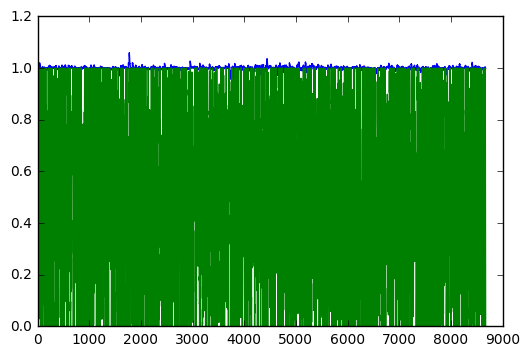

In [43]:
plt.plot(test_data_x)
plt.plot(test_data_y)

In [44]:
#ネットワークを試す関数
def evaluate(model, x, y):
    evaluator = model.copy()
    evaluator.reset_state()
    out = evaluator.predict(x)
    error = F.mean_squared_error(out, y)
    return chainer.cuda.to_cpu(out.data), error.data

In [45]:
model = Net(1, n_units, 1)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
test_loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
x_cache = []
y_cache = []
x_chainer_variable = chainer.Variable(xp.asarray(train_data_x, dtype=np.float32))
y_chainer_variable = chainer.Variable(xp.asarray(train_data_y, dtype=np.float32))
test_data_x_chainer_variable = chainer.Variable(xp.asarray(test_data_x, dtype=np.float32))
test_data_y_chainer_variable = chainer.Variable(xp.asarray(test_data_y, dtype=np.float32))
prev_time = time.time()
for i in range(jump * n_epoch):
    if len(x_cache) <= i % jump:
        x_cache.append( chainer.Variable(xp.asarray([train_data_x[(jump * j + i) % length] for j in batch_idxs])))
        y_cache.append( chainer.Variable(xp.asarray([train_data_y[(jump * j + i) % length] for j in batch_idxs])))
    x = x_cache[i % jump]
    y = y_cache[i % jump]
    #x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    #y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % printout_interval == 0:
            now = time.time()
            elapsed_time = now - prev_time
            prev_time = now
            speed = printout_interval / elapsed_time
            eta = datetime.timedelta(seconds = (n_epoch - epoch) / speed)
            eta = datetime.timedelta(seconds = eta.seconds)
            print('epoch {0}, error {1}, {2:.2f} epoch/s, eta {3}'.format(epoch, loss_data * len(x) / length, speed, eta))
        loss.append(evaluate(model, x_chainer_variable, y_chainer_variable)[1])
        test_loss.append(evaluate(model, test_data_x_chainer_variable, test_data_y_chainer_variable)[1])
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 1000, error 7.064964294433594, 62.45 epoch/s, eta 0:26:25
epoch 2000, error 7.051173210144043, 62.15 epoch/s, eta 0:26:16
epoch 3000, error 7.049762725830078, 62.69 epoch/s, eta 0:25:47
epoch 4000, error 7.048286437988281, 63.94 epoch/s, eta 0:25:01
epoch 5000, error 7.0463786125183105, 64.41 epoch/s, eta 0:24:34
epoch 6000, error 7.043621063232422, 64.25 epoch/s, eta 0:24:23
epoch 7000, error 7.038463115692139, 64.06 epoch/s, eta 0:24:11
epoch 8000, error 7.021248817443848, 64.20 epoch/s, eta 0:23:53
epoch 9000, error 7.0005950927734375, 64.13 epoch/s, eta 0:23:38
epoch 10000, error 6.968145370483398, 64.19 epoch/s, eta 0:23:22
epoch 11000, error 6.939039707183838, 64.36 epoch/s, eta 0:23:02
epoch 12000, error 6.9116010665893555, 60.61 epoch/s, eta 0:24:11
epoch 13000, error 6.900452136993408, 60.70 epoch/s, eta 0:23:53
epoch 14000, error 6.89865255355835, 63.58 epoch/s, eta 0:22:32
epoch 15000, error 6.898744583129883, 56.82 epoch/s, eta 0:24:56
epoch 16000, error 6.89840364456

In [46]:
#モデルを保存
serializers.save_npz('my.model', model)

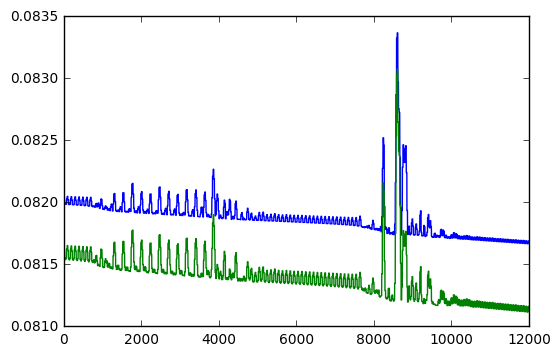

In [47]:
plt.plot(loss[-12000:])
plt.plot(test_loss[-12000:])

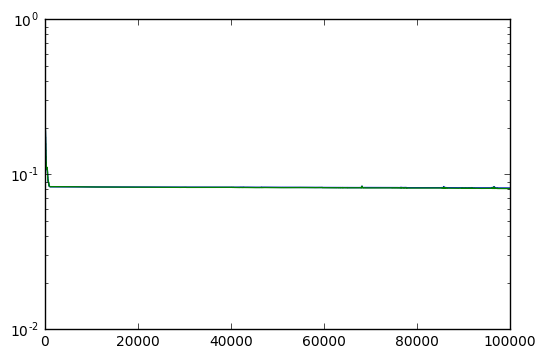

In [48]:
plt.plot(loss)
plt.plot(test_loss)
plt.yscale('log')

In [49]:
output, error = evaluate(model, x_chainer_variable, y_chainer_variable)

print(error)

0.08168797940015793


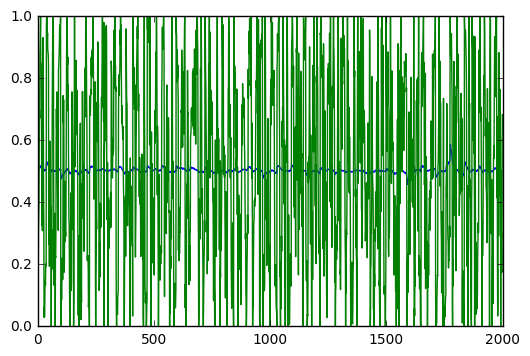

In [50]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

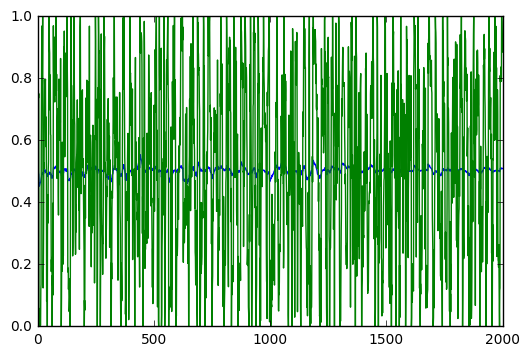

In [51]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])

In [52]:
output, error = evaluate(model, test_data_x_chainer_variable, test_data_y_chainer_variable)
print('test error = {}'.format(error))

test error = 0.08115905523300171


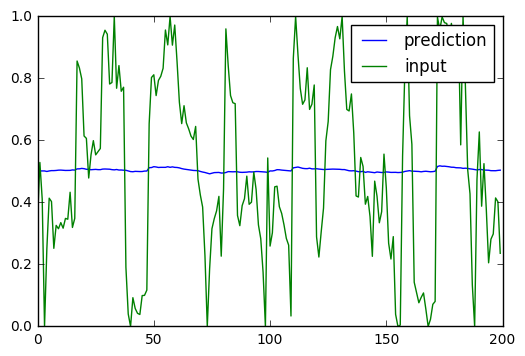

In [53]:
plt.plot(output[300:500, 0], label='prediction')
plt.plot(test_data_y[300:500, 0], label='input')
plt.legend()